In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gpxpy
from scipy.optimize import milp, LinearConstraint, Bounds
from collections import defaultdict
import random
import math
from collections import Counter
from IPython.display import display, HTML
import io
import base64
from pathlib import Path

In [49]:
def charger_trace(gpx_path):
    with open(gpx_path, 'r',encoding="utf-8") as gpx_file:
        gpx = gpxpy.parse(gpx_file)
        distances = []
        altitudes = []
        times = []
        cum_distance = 0
        last_point = None

        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    if last_point:
                        dist = point.distance_3d(last_point) / 1000
                        cum_distance += dist
                        distances.append(cum_distance)
                        altitudes.append(point.elevation)
                        times.append(point.time)
                    else:
                        distances.append(0)
                        altitudes.append(point.elevation)
                        times.append(point.time)
                    last_point = point
        return pd.DataFrame({"distance": distances, "altitude": altitudes, "time": times})
    
def arrondir_a_5min(temps):
    x = 1 #5
    return round(temps * 60 / x) * x / 60

def formater_duree(duree_h):
    duree_h = arrondir_a_5min(duree_h) 
    heures = int(duree_h)
    minutes = int(round((duree_h - heures) * 60))
    return f"{heures}h {minutes}min"


def convertir_en_heures(duree_str):
    """Convertit une chaîne de type '10h 55min' en nombre d'heures float."""
    h, m = 0, 0
    if 'h' in duree_str:
        parts = duree_str.split('h')
        h = int(parts[0].strip())
        if 'min' in parts[1]:
            m = int(parts[1].split('min')[0].strip())
    elif 'min' in duree_str:
        m = int(duree_str.split('min')[0].strip())
    return h + m / 60



def estimer_temps(df, ravitos, temps_cible, montee=10, descente=2, fatigue_max=0.3):
    segments = []
    nb_segments = len(ravitos) - 1
    efforts_pondérés = []

    for i in range(nb_segments):
        d1, d2 = ravitos[i], ravitos[i + 1]
        seg_df = df[(df["distance"] >= d1) & (df["distance"] <= d2)]
        distance = d2 - d1
        dplus = seg_df["altitude"].diff().clip(lower=0).sum()
        dminus = -seg_df["altitude"].diff().clip(upper=0).sum()
        effort = distance + montee * (dplus / 1000) + descente * (dminus / 1000)
        fatigue_coeff = 1.0 + (i / (nb_segments - 1)) * fatigue_max if nb_segments>1 else 1.0
        efforts_pondérés.append((effort, fatigue_coeff, d1, d2, dplus, dminus))

    effort_total_pondéré = sum(e * f for e, f, *_ in efforts_pondérés)
    temps_total_minutes = temps_cible * 60
    minutes_par_effort_pondéré = temps_total_minutes / effort_total_pondéré

    for effort, fatigue_coeff, d1, d2, dplus, dminus in efforts_pondérés:
        effort_pondéré = effort * fatigue_coeff
        temps_segment_minutes = effort_pondéré * minutes_par_effort_pondéré
        duree_h = arrondir_a_5min(temps_segment_minutes / 60)

        segments.append({
            "km_debut": d1,
            "km_fin": d2,
            "duree_h": duree_h,
            "D+": int(dplus),
            "D-": int(dminus)
        })

    return segments




def glucides_par_boisson(segments,ingredients, max_flasques):
    glucides_par_flasque = [ing['glucides'] for _, ing in enumerate(ingredients) if ing.get("categorie") == "liquide"][0]
    resultats = []

    for seg in segments:
        duree_h = seg["duree_h"]

        flasques = round((duree_h * 2) + 0.499999) / 2  # arrondi au 0.5 supérieur
        #flasques = round(duree_h * 2) / 2 
        flasques = min(flasques, max_flasques)

        glucides_total = flasques * glucides_par_flasque
        glucides_par_heure = glucides_total / duree_h

        resultats.append({
            "km_debut": seg["km_debut"],
            "km_fin": seg["km_fin"],
            "D+": seg["D+"],
            "D-": seg["D-"],
            "duree_h": duree_h,
            "flasques": flasques,
            "glucides_boire_total": glucides_total,
            "glucides_boire_par_h": round(glucides_par_heure, 2)
        })

    return resultats

def glucides_par_heure(segments):
    heure_glucides = defaultdict(float)
    heure_duree = defaultdict(float)
    temps_total = 0
    for seg in segments:
        duree_h = seg["duree_h"]
        gph = seg["glucides_boire_par_h"]

        temps_restant = duree_h
        while temps_restant > 0:
            heure_idx = math.floor(temps_total)
            temps_dans_heure = min(1 - (temps_total % 1), temps_restant)

            heure_glucides[heure_idx] += gph * temps_dans_heure
            heure_duree[heure_idx] += temps_dans_heure

            temps_total += temps_dans_heure
            temps_restant -= temps_dans_heure

    heures = sorted(heure_glucides.keys())
    data = []
    for h in heures:
        glucides_moyen = heure_glucides[h] / heure_duree[h]
        data.append({
            "heure": h + 1,
            "glucides_boire_par_h": round(glucides_moyen, 2),
            "duree_h": round(heure_duree[h], 2)
        })

    return pd.DataFrame(data)


def plot_allure_estimee(segments):
    km_centres = [(s["km_debut"] + s["km_fin"]) / 2 for s in segments]
    allure = [60 * (s["duree_h"] / (s["km_fin"] - s["km_debut"])) for s in segments]  # min/km
    plt.figure(figsize=(10, 5))
    plt.plot(km_centres, allure, marker='o')
    plt.xlabel("Distance (km)")
    plt.ylabel("Allure estimée (min/km)")
    plt.title("Allure estimée par segment")
    plt.grid(True)
    plt.show()  



def get_ingredient_cafeine(ingredients):
    ingredients_cafeines = [ing for ing in ingredients if ing.get("cafeine", 0) > 0]
    if ingredients_cafeines:
        ing_min = min(ingredients_cafeines, key=lambda x: x["cafeine"])
        cafeine_min, glucides = ing_min["cafeine"], ing_min["glucides"]
    else:
        cafeine_min = glucides = None
    return cafeine_min, glucides

def get_duree_cafeine_h(duree_cible, cafeine_max, ingredients):
    cafeine_min, _ = get_ingredient_cafeine(ingredients)
    if cafeine_min is None:
        return 1
    for h in range(1, int(duree_cible) + 1):
        cafeine_par_cut = cafeine_max * h / duree_cible
        if cafeine_par_cut >= cafeine_min:
            return h  
    return int(duree_cible)

def optimisation(glucides_cible, df_glucides_h, ingredients, duree_cible, cafeine_max): 
    usage_counter = defaultdict(int)
    cafeine_min, glucides_min = get_ingredient_cafeine(ingredients)
    duree_cafeine_h = get_duree_cafeine_h(duree_cible,cafeine_max, ingredients)
    resultats_par_heure = []

    cafeine_par_cut = cafeine_max * duree_cafeine_h / duree_cible

    cafeine_cumulee_cut = 0

    for _, row in df_glucides_h.iterrows():
        heure = int(row["heure"])
        glucides_boire = row["glucides_boire_par_h"]
        glucides_restants = glucides_cible - glucides_boire
        if (heure -1) % duree_cafeine_h == 0:
            cafeine_cumulee_cut = 0

        if glucides_restants <= 0:
            resultats_par_heure.append({
                "heure": heure,
                "glucides_liquide": glucides_boire,
                "glucides_solide": 0,
                "total_glucides": glucides_boire,
                "ingredients_solides": {},
                "cafeine": 0
            })
            continue

        solides = [ing for ing in ingredients if ing.get("categorie") != "liquide"]
        n = len(solides)
        glucides = np.array([ing["glucides"] for ing in solides])
        cafeines = np.array([ing.get("cafeine", 0) for ing in solides])

        lb = np.zeros(n)
        ub = np.full(n, 100.0)
        integrality = np.ones(n, dtype=int)

        glucides_total_min = glucides_cible * 0.85
        glucides_total_max = glucides_cible * 1.15
        glucides_restants_min = max(0, glucides_total_min - glucides_boire)
        glucides_restants_max = glucides_total_max - glucides_boire

        constraints = [LinearConstraint([glucides], [glucides_restants_min], [glucides_restants_max])]


        cafeine_restante_cut = cafeine_par_cut - cafeine_cumulee_cut
        if np.any(cafeines > 0):
            if (cafeine_restante_cut >= cafeine_min) & (glucides_restants_max >= glucides_min) & (heure>1):
                constraints.append(LinearConstraint([cafeines], [cafeine_min], [cafeine_restante_cut]))
            else:
                constraints.append(LinearConstraint([cafeines], [0], [0]))
        res = milp(
            c=np.array([1 + 0.1 * usage_counter[ing["nom"]] for ing in solides]),#np.array([1] * n),
            integrality=integrality,
            bounds=Bounds(lb, ub),
            constraints=constraints
        )

        if res.success:
            ingredients_solides = {}
            total_glucides_solides = 0
            total_cafeine = 0
            for i, ing in enumerate(solides):
                portion = int(round(res.x[i]))
                if portion > 0:
                    nom = ing["nom"]
                    ingredients_solides[nom] = portion
                    total_glucides_solides += portion * ing["glucides"]
                    total_cafeine += portion * ing.get("cafeine", 0)

            cafeine_cumulee_cut += total_cafeine
            total = glucides_boire + total_glucides_solides

            resultats_par_heure.append({
                "heure": heure,
                "glucides_liquide": round(glucides_boire, 2),
                "glucides_solide": round(total_glucides_solides, 2),
                "total_glucides": round(total, 2),
                "ingredients_solides": ingredients_solides,
                "cafeine": round(total_cafeine, 2)
            })
        else:
            print(f"⚠️ Optimisation échouée pour l’heure {heure}: {res.message}")
            resultats_par_heure.append({
                "heure": heure,
                "glucides_liquide": round(glucides_boire, 2),
                "glucides_solide": 0,
                "total_glucides": round(glucides_boire, 2),
                "ingredients_solides": {"erreur": "optimisation échouée"},
                "cafeine": 0
            })
            
        for i, ing in enumerate(solides):
            portion = int(round(res.x[i]))
            if portion > 0:
                usage_counter[ing["nom"]] += portion

    resultats_par_heure = pd.DataFrame(resultats_par_heure)
    resultats_par_heure = uniformiser_ingredients(resultats_par_heure, ingredients)
    resultats_par_heure = ajouter_timing(resultats_par_heure, ingredients)
    return resultats_par_heure


def uniformiser_ingredients(df, ingredients):
    # Créer un dictionnaire d'ingrédients équivalents (par glucides), sans caféine
    glucides_equivalents = {}
    preferences_map = {}

    for ing in ingredients:
        nom = ing["nom"]
        glucides = ing["glucides"]
        cafeine = ing.get("cafeine", 0)
        preference = ing.get("preference", 1.0)  # par défaut = 1.0

        preferences_map[nom] = preference

        if cafeine > 0:
            continue
        if glucides not in glucides_equivalents:
            glucides_equivalents[glucides] = []
        glucides_equivalents[glucides].append(nom)

    # Appliquer la répartition pondérée
    for index, row in df.iterrows():
        ingredients_solides = row['ingredients_solides']
        updated_ingredients_solides = {}

        for ingredient, quantity in ingredients_solides.items():
            # Conserver les ingrédients caféinés tels quels
            ing_cafeine = next((ing.get("cafeine", 0) for ing in ingredients if ing["nom"] == ingredient), 0)
            if ing_cafeine > 0:
                updated_ingredients_solides[ingredient] = quantity
                continue

            glucides_val = next((ing["glucides"] for ing in ingredients if ing["nom"] == ingredient), None)
            if glucides_val is None:
                continue

            equivalent_ingredients = glucides_equivalents.get(glucides_val, [ingredient])
            if quantity > 1 and len(equivalent_ingredients) > 1:
                # Obtenir les préférences pour les ingrédients équivalents
                prefs = np.array([preferences_map.get(ing, 1.0) for ing in equivalent_ingredients], dtype=float)
                prefs /= prefs.sum()  # Normalisation

                portions = np.floor(prefs * quantity).astype(int)
                remainder = quantity - portions.sum()

                # Distribuer le reste au top préférés
                indices = np.argsort(-prefs)
                for i in range(remainder):
                    portions[indices[i % len(indices)]] += 1

                for i, ing_name in enumerate(equivalent_ingredients):
                    if portions[i] > 0:
                        updated_ingredients_solides[ing_name] = int(portions[i])
            else:
                # Choix aléatoire pondéré selon la préférence
                chosen = random.choices(
                    population=equivalent_ingredients,
                    weights=[preferences_map.get(ing, 1.0) for ing in equivalent_ingredients],
                    k=1
                )[0]
                updated_ingredients_solides[chosen] = quantity

        updated_ingredients_solides = {k: v for k, v in updated_ingredients_solides.items() if v > 0}
        df.at[index, 'ingredients_solides'] = updated_ingredients_solides

    return df




def ajouter_timing(df, ingredients):
    glucides_map = {ing["nom"]: ing["glucides"] for ing in ingredients if ing["categorie"] == "solide"}

    all_timings = []

    for _, row in df.iterrows():
        heure_debut = row['heure'] - 1 
        timing_row = {}
        ingredients_list = []

        for ingr in sorted(row['ingredients_solides']):
            qty = row['ingredients_solides'][ingr]
            for _ in range(qty):
                if ingr in glucides_map:
                    ingredients_list.append((ingr, glucides_map[ingr]))

        n = len(ingredients_list)
        if n == 0:
            all_timings.append({})
            continue

        for idx, (ingr, _) in enumerate(ingredients_list):
            offset = (idx + 0.5) / n  # positionnement au centre de l'intervalle
            timing = round(heure_debut + offset, 2)
            timing_row[ingr] = timing

        all_timings.append(timing_row)

    df['timing'] = all_timings
    return df


def ajouter_timing_segments(segments,plan):
    timing = plan['timing'].to_list()
    current_time = 0
    for segment in segments:
        segment["heure_debut"] = current_time
        segment["heure_fin"] = current_time + segment["duree_h"]
        current_time = segment["heure_fin"]
        segment["timing"] = [{} for _ in range(int(segment["duree_h"]) + 1)]  

    for entry in timing:
        for ingr, heure in entry.items():
            for segment in segments:
                if segment["heure_debut"] <= heure < segment["heure_fin"]:
                    heure_locale = heure - segment["heure_debut"]
                    index_horaire_local = int(heure_locale) 
                    dico = segment["timing"][index_horaire_local]
                    if ingr in dico:
                        dico[ingr].append(heure)
                    else:
                        dico[ingr] = [heure]
                    break
    return segments

def formater_timing(timing_raw):
    timing_formatted = []
    for t in timing_raw:
        formatted = {}
        for ing, heures in t.items():
            heures_formatees = [formater_duree(h) for h in heures]
            if len(heures_formatees) == 1:
                formatted[ing] = heures_formatees[0]
            else:
                formatted[ing] = heures_formatees
        if formatted:  # on n'ajoute que si non vide
            timing_formatted.append(formatted)
    return timing_formatted

def construire_dataframe(segments,ingredients):
    glucides_par_ingredient = {i["nom"]: i["glucides"] for i in ingredients if i["categorie"] == "solide"}
    data = []
    for segment in segments:
        flasques = segment['flasques']
        km_debut = segment['km_debut']
        km_fin = segment['km_fin']
        d_plus = segment['D+']
        d_minus = segment['D-']
        duree_h = segment['duree_h']
        duree_formatee = formater_duree(duree_h)
        glucides_liquide = segment.get('glucides_boire_total', 0)
        timing_raw = segment.get("timing", [])
        timing_formatted = formater_timing(timing_raw)

        ingredients_solides = {}
        glucides_solide = 0

        for t in timing_raw:
            for ing, heures in t.items():
                count = len(heures)
                ingredients_solides[ing] = ingredients_solides.get(ing, 0) + count
                glucides_solide += count * glucides_par_ingredient.get(ing, 0)

        glucides_total = glucides_liquide + glucides_solide

        data.append({
            "km_debut": km_debut,
            "km_fin": km_fin,
            "D+": d_plus,
            "D-": d_minus,
            "durée": duree_formatee,
            "flasques": flasques,
            "glucides_liquide": glucides_liquide,
            "glucides_solide": glucides_solide,
            "glucides_total": glucides_total,
            "ingrédients_solides": ingredients_solides,
            "timing": timing_formatted
        })

    results = pd.DataFrame(data)
    duree = [convertir_en_heures(results['durée'][i]) for i in range(len(results))]
    x = [0] + list(np.cumsum(duree)[:-1])
    x = [formater_duree(i) for i in x]
    results['durée_cumulée'] = x
    results = results[['km_debut', 'km_fin', 'D+', 'D-', 'durée','durée_cumulée','glucides_total','glucides_solide','ingrédients_solides', 'timing','glucides_liquide','flasques']]
    results = formatter_timing(results)
    results["timing"] = results["timing"].str.replace("\n", "<br>")
    return results

def formatter_timing(df):
    lignes_formattées = []
    for timings in df["timing"]:
        ligne = []
        for d in timings:
            for nom, t in d.items():
                ligne.append(f"{t} → {nom}")
        lignes_formattées.append("\n".join(ligne))
    df["timing"] = lignes_formattées
    return df

def generator(gpx,ravitos_km,temps_cible_total_heures,montee,descente,fatigue_max,ingredients,nombre_flasques,glucides_cibles_g_h,cafeine_max,seed):
    random.seed(seed)
    segments = estimer_temps(gpx, ravitos_km,temps_cible_total_heures,montee,descente,fatigue_max)
    segments = glucides_par_boisson(segments,ingredients,nombre_flasques)
    df_glucides_h = glucides_par_heure(segments)
    plan = optimisation(glucides_cibles_g_h, df_glucides_h, ingredients,temps_cible_total_heures, cafeine_max)
    segments = ajouter_timing_segments(segments,plan)
    results = construire_dataframe(segments,ingredients)
    return results,plan


In [40]:
GLUCIDES_CIBLES_G_H = 90
NOMBRE_FLASQUES = 2
TEMPS_CIBLE_TOTAL_HEURES = 12
CAFEINE_MAX = 400
MONTEE = 10 
DESCENTE = 2
FATIGUE_MAX = 0.3
SEED = 42 

INGREDIENTS = [
    {"nom": "puree", "marque" : "naak","glucides": 25, "volume_ml": None, "categorie": "solide", "cafeine":0,"preference":1,"presence":True},
    {"nom": "gel", "marque" : "maurten","glucides": 25, "volume_ml": None, "categorie": "solide", "cafeine":0,"preference":1,"presence":True},
    {"nom": "gel caf", "marque" : "maurten","glucides": 25, "volume_ml": None, "categorie": "solide", "cafeine":100,"preference":1,"presence":True},
    {"nom": "boisson", "marque" : "naak", "glucides": 55, "volume_ml": 500, "categorie": "liquide", "cafeine":0,"preference":1,"presence":True},
    {"nom": "pate de fruits", "marque" : "decathlon","glucides": 20, "volume_ml": None, "categorie": "solide", "cafeine":0,"preference":1,"presence":False},
    {"nom": "barre amande", "marque" : "decathlon","glucides": 14, "volume_ml": None, "categorie": "solide", "cafeine":0,"preference":1,"presence":False},
    {"nom": "barre nougat", "marque" : "decathlon","glucides": 14, "volume_ml": None, "categorie": "solide", "cafeine":0,"preference":1,"presence":False}
]
INGREDIENTS = [ingredient for ingredient in INGREDIENTS if ingredient.get("presence", False)]

RAVITOS_KM = [0, 14.7, 20.9, 30.8, 41, 48.8, 58.7,69.7, 77.9]

TRAIL = 'ANDORRA'
GPX_PATH = "andorra_80.gpx"
gpx = charger_trace(GPX_PATH)

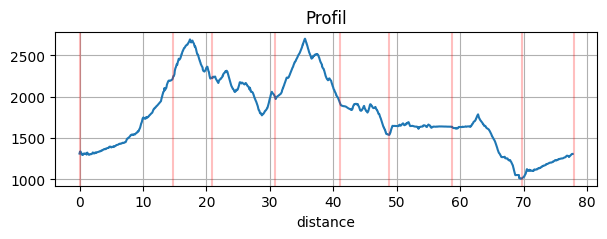

,km_debut,km_fin,D+,D-,durée,durée_cumulée,flasques,timing
0,0.0,14.7,1126,226,2h 6min,0h 0min,2.0,0h 30min → gel1h 30min → gel caf
1,14.7,20.9,585,581,1h 6min,2h 6min,1.5,2h 30min → puree
2,20.9,30.8,642,865,1h 34min,3h 12min,2.0,3h 30min → gel caf4h 30min → puree
3,30.8,41.0,829,893,1h 50min,4h 46min,2.0,5h 30min → puree6h 30min → gel caf
4,41.0,48.8,286,675,1h 7min,6h 36min,1.5,7h 30min → puree
5,48.8,58.7,387,287,1h 23min,7h 43min,1.5,8h 30min → gel
6,58.7,69.7,280,907,1h 34min,9h 6min,2.0,9h 30min → gel caf10h 30min → puree
7,69.7,77.9,430,133,1h 19min,10h 40min,1.5,11h 30min → gel


,Trail,Distance,D+,D-,Durée (h),Glucides (g/h),Boisson (mL/h),Caféine (mg)
0,ANDORRA,77.9,4565,4567,12,89.2,583,400


,Ingrédient,Quantité
0,gel,3
1,gel caf,4
2,puree,5
3,boisson,14.0


In [ ]:
run = False
if run:
    results,plan = generator(gpx,RAVITOS_KM,TEMPS_CIBLE_TOTAL_HEURES,MONTEE,DESCENTE,FATIGUE_MAX,INGREDIENTS,NOMBRE_FLASQUES,GLUCIDES_CIBLES_G_H,CAFEINE_MAX,SEED)
    #results.to_parquet('results.pq')

    resume_data = {
        "Trail": [TRAIL],
        "Distance": [results.km_fin.iloc[-1]],
        "D+": [results["D+"].sum()],
        "D-": [results["D-"].sum()],
        "Durée (h)": [TEMPS_CIBLE_TOTAL_HEURES],
        "Glucides (g/h)": [np.round(results.glucides_total.sum() / TEMPS_CIBLE_TOTAL_HEURES, 1)],
        "Boisson (mL/h)": [int(results.flasques.sum() * 500 / TEMPS_CIBLE_TOTAL_HEURES)],
        "Caféine (mg)": [int(plan.cafeine.sum())],
    }
    df_resume = pd.DataFrame(resume_data)

    total_ingredients = Counter()
    for d in results["ingrédients_solides"]:
        total_ingredients.update(d)
    df_ingredients = pd.DataFrame(list(total_ingredients.items()),columns=["Ingrédient", "Quantité"])
    df_ingredients = pd.concat([df_ingredients.T,pd.Series(['boisson',results.flasques.sum()],index=['Ingrédient','Quantité'])],axis=1).T.reset_index(drop=True)
    plt.figure(figsize=(7,2))
    gpx.set_index('distance').altitude.plot()
    for rvt in RAVITOS_KM:
        plt.axvline(x=rvt,color='red',alpha=.25)
    plt.grid()
    plt.title('Profil')
    plt.show()
    display(HTML(results[['km_debut', 'km_fin', 'D+', 'D-', 'durée', 'durée_cumulée', 'flasques', 'timing']].to_html(escape=False)))
    display(df_resume)
    display(df_ingredients)

In [9]:
html = False
if html:
    # 1. Génère l'image du profil altimétrique
    fig, ax = plt.subplots(figsize=(10, 3))
    gpx.set_index("distance").altitude.plot(ax=ax)
    for rvt in RAVITOS_KM:
        ax.axvline(x=rvt, color='red', alpha=0.25)
    ax.set_title('Profil')
    ax.set_xlabel("distance")
    ax.set_ylabel("altitude")
    ax.grid()

    # Sauvegarde en mémoire (base64)
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()

    # 2. Génère les tableaux HTML
    table_results = results[['km_debut', 'km_fin', 'D+', 'D-', 'durée', 'durée_cumulée', 'flasques', 'timing']].to_html(index=False, escape=False)
    table_resume = df_resume.to_html(index=False)
    table_ingredients = df_ingredients.to_html(index=False)

    # 3. Construit le HTML
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <title>Plan Nutrition - {TRAIL}</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; font-size: 10px}}
            table {{ border-collapse: collapse; width: 100%; margin-bottom: 30px;font-size: 10px }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: center; font-size: 10px}}
            th {{ background-color: #f2f2f2; }}
            h2 {{ margin-top: 40px; }}
            img {{ width: 100%; max-width: 800px; }}
        </style>
    </head>
    <body>
        <h1>Plan Nutrition – {TRAIL}</h1>
        <img src="data:image/png;base64,{img_base64}" alt="Profil altimétrique">
        
        <h2>Résumé</h2>
        {table_resume}

        <h2>Ingrédients</h2>
        {table_ingredients}

        <h2>Détails par segment</h2>
        {table_results}

    </body>
    </html>
    """

    # 4. Sauvegarde dans un fichier HTML
    Path("plan_nutrition_detaille.html").write_text(html, encoding='utf-8')
    print("✅ Fichier HTML généré : plan_nutrition_detaille.html")


    # 1. Génère l'image du profil altimétrique
    fig, ax = plt.subplots(figsize=(6, 3))
    gpx.set_index("distance").altitude.plot(ax=ax)
    for rvt in RAVITOS_KM:
        ax.axvline(x=rvt, color='red', alpha=0.25)
    ax.set_title('Profil')
    ax.set_xlabel("distance")
    ax.set_ylabel("altitude")
    ax.grid()

    # Sauvegarde en mémoire (base64)
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()

    # 2. Génère les tableaux HTML
    table_results = results[['km_debut', 'km_fin', 'durée_cumulée', 'flasques', 'timing']].to_html(index=False, escape=False)

    # 3. Construit le HTML
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; font-size: 20px}}
            table {{ border-collapse: collapse; width: 100%; margin-bottom: 30px;font-size: 20px }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: center; font-size: 20px}}
            th {{ background-color: #f2f2f2; }}
            h2 {{ margin-top: 40px; }}
            img {{ width: 100%; max-width: 800px; }}
        </style>
    </head>
    <body>
        <img src="data:image/png;base64,{img_base64}" alt="Profil altimétrique">
        
        {table_results}

    </body>
    </html>
    """

    # 4. Sauvegarde dans un fichier HTML
    Path("timing_nutrition.html").write_text(html, encoding='utf-8')
    print("✅ Fichier HTML généré : timing_nutrition.html")
